In [7]:
import math
import time

from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta

from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler

from pprint import pprint

## dataset load

In [8]:
df_md = pd.read_csv('/kaggle/input/autoscaler-log-2/2_bilstmmd_autoscaler_log_20250705_181512.csv',
                   usecols=["timestamp", "current_replicas", "current_request", "predicted_request"],
                   index_col=["timestamp"],
                   parse_dates=["timestamp"]
                  ).sort_index()

df_md = df_md.fillna(0)

replicas_md = df_md['current_replicas'].tolist()
current_request_md = df_md['current_request'].tolist()
predicted_request_md = df_md['predicted_request'].tolist()

## helper

### kubernetes default HPA algorithm class

In [9]:
class HpaHttpScaler:
    """
    Replicas of Kubernetes Autoscaler algorithm with HTTP-based that calculates desired replica counts
    based on incoming request rates and target utilization.
    
    This scaler implements HPA logic with cooldown periods, tolerance thresholds,
    and rate limiting to prevent rapid scaling oscillations.
    """
    
    def __init__(self, target_requests_per_pod: int, target_utilization_percentage: int = 70):
        """
        Initialize the HPA HTTP scaler.
        
        Args:
            target_requests_per_pod (int): Maximum requests per pod capacity
            target_utilization_percentage (int): Target utilization as percentage of capacity (default: 70)
        """
        self.target_requests_per_pod = target_requests_per_pod
        self.target_utilization_percentage = target_utilization_percentage
        
        self.effective_target = (target_requests_per_pod * target_utilization_percentage) / 100

        self.scale_up_cooldown: timedelta = timedelta(minutes=3)
        self.scale_down_cooldown: timedelta = timedelta(minutes=5)
        self.tolerance = 0.1
        
        current_time = datetime.now()
        self.last_scale_up_time: datetime = current_time - self.scale_up_cooldown
        self.last_scale_down_time: datetime = current_time - self.scale_down_cooldown
    
    def get_desired_replicas(
        self, 
        current_replicas: int, 
        current_requests: int,
        current_time: datetime = None
    ):
        """
        Calculate the desired number of replicas based on current load.
        
        Args:
            current_replicas (int): Current number of pod replicas
            current_requests (int): Current number of incoming requests
            current_time (datetime, optional): Time for cooldown calculations (defaults to now)
            
        Returns:
            int: Desired number of replicas
        """
        if current_time is None:
            current_time = datetime.now()
        
        if current_replicas <= 0:
            return 1
        
        if self.effective_target <= 0:
            return current_replicas
        
        if current_requests == 0:
            return current_replicas
        
        current_requests_per_pod = current_requests / current_replicas
        utilization_ratio = current_requests_per_pod / self.effective_target
        
        if abs(utilization_ratio - 1.0) < self.tolerance:
            return current_replicas
        
        raw_desired_replicas = max(1, math.ceil(current_replicas * utilization_ratio))
        
        scaling_up = raw_desired_replicas > current_replicas
        scaling_down = raw_desired_replicas < current_replicas
        
        if scaling_up:
            time_since_scale_up = current_time - self.last_scale_up_time
            if time_since_scale_up < self.scale_up_cooldown:
                return current_replicas
                    
        if scaling_down:
            time_since_scale_down = current_time - self.last_scale_down_time
            if time_since_scale_down < self.scale_down_cooldown:
                return current_replicas
        
        if scaling_up:
            max_scale_up = math.ceil(current_replicas * 2)
            desired_replicas = min(raw_desired_replicas, max_scale_up)
            
            if desired_replicas > current_replicas:
                self.last_scale_up_time = current_time
            else:
                desired_replicas = current_replicas
                
        elif scaling_down:
            min_scale_down = max(1, math.ceil(current_replicas * 0.5))
            desired_replicas = max(raw_desired_replicas, min_scale_down)
            
            if desired_replicas < current_replicas:
                self.last_scale_down_time = current_time
            else:
                desired_replicas = current_replicas
        else:
            desired_replicas = current_replicas
        
        return desired_replicas

<!-- ### ai scaling algorithm class -->

### get request and pods data function

In [10]:
def process_autoscaler_data(
    filtered_data, 
    default_autoscaler_instance: HpaHttpScaler,
    initial_replicas: int,
    start_time: datetime = None
    ):
    """
    Process autoscaler data by simulating replica scaling over time.
    
    This function iterates through request data and calculates the desired
    number of replicas at each time step using the provided HPA scaler.
    
    Args:
        filtered_data: Array-like of request counts over time
        default_autoscaler_instance (HpaHttpScaler): HPA scaler instance to calculate replicas
        initial_replicas (int): Starting number of replicas
        start_time (datetime, optional): Starting time for simulation (defaults to now)
        
    Returns:
        list: List of replica counts at each time step
    """
    
    request_list = []
    default_pods_list = []
    
    iterator = len(filtered_data)

    current_default_replicas = initial_replicas
    current_ai_replicas = initial_replicas
    
    if start_time is None:
        start_time = datetime.now()
    current_time = start_time

    for i in range(iterator):
        current_request = filtered_data[i]
        request_list.append(current_request)

        result_hpa_replicas = default_autoscaler_instance.get_desired_replicas(
            current_replicas=current_default_replicas, 
            current_requests=current_request,
            current_time=current_time
        )
        current_default_replicas = result_hpa_replicas
        default_pods_list.append(result_hpa_replicas)

        current_time = current_time + timedelta(minutes=1)
    
    return default_pods_list

### autoscaler metrics evaluator class

In [11]:
class AutoscalerEvaluator:
    """
    Evaluates autoscaler performance using metrics from research paper:
    - ΘU[%]: Under-provisioning metric
    - ΘO[%]: Over-provisioning metric  
    - TU[%]: Time duration under-provisioned
    - TO[%]: Time duration over-provisioned
    - εn: Elastic speedup (autoscaling gain vs no autoscaling)
    """
    
    def __init__(self, workload_per_pod: int, initial_replicas: int):
        """
        Initialize the AutoscalerEvaluator.
        
        Args:
            workload_per_pod (int): Maximum workload capacity per pod
            initial_replicas (int): Initial number of replicas
        """
        self.workload_per_pod = workload_per_pod
        self.initial_replicas = initial_replicas
        
    def _calculate_required_pods(self, requests: List[int]):
        """
        Calculate required pods with proper validation.
        
        Args:
            requests (List[int]): List of request counts over time
            
        Returns:
            List[int]: List of required pod counts
            
        Raises:
            ValueError: If request values are negative
        """
        if not requests:
            return []
        
        if any(req < 0 for req in requests):
            raise ValueError("Request values cannot be negative")
            
        return [max(1, math.ceil(req / self.workload_per_pod)) for req in requests]
    
    def _validate_inputs(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Common input validation for metric calculations.
        
        Args:
            required_pods (List[int]): List of required pod counts
            provisioned_pods (List[int]): List of provisioned pod counts
            
        Raises:
            ValueError: If lists have different lengths, are empty, or contain negative values
        """
        if len(required_pods) != len(provisioned_pods):
            raise ValueError("Required and provisioned pods lists must have same length")
        
        if not required_pods:
            raise ValueError("Input lists cannot be empty")
            
        if any(p < 0 for p in required_pods + provisioned_pods):
            raise ValueError("Pod counts cannot be negative")
    
    def _calculate_theta_u(self, required_pods: List[int], provisioned_pods: List[int], delta_t: float = 1.0):
        """
        Calculate under-provisioning metric ΘU[%].
        ΘU[%] = (100/T) * Σ(max(rt - pt, 0)/rt) * Δt
        
        Args:
            required_pods (List[int]): List of required pod counts
            provisioned_pods (List[int]): List of provisioned pod counts
            delta_t (float): Time delta between measurements (default: 1.0)
            
        Returns:
            float: Under-provisioning metric as percentage
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        theta_u_sum = 0.0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:
                theta_u_sum += (max(rt - pt, 0) / rt) * delta_t
        
        return (100.0 / T) * theta_u_sum
    
    def _calculate_theta_o(self, required_pods: List[int], provisioned_pods: List[int], delta_t: float = 1.0):
        """
        Calculate over-provisioning metric ΘO[%].
        ΘO[%] = (100/T) * Σ(max(pt - rt, 0)/rt) * Δt
        
        Args:
            required_pods (List[int]): List of required pod counts
            provisioned_pods (List[int]): List of provisioned pod counts
            delta_t (float): Time delta between measurements (default: 1.0)
            
        Returns:
            float: Over-provisioning metric as percentage
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        theta_o_sum = 0.0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > 0:
                theta_o_sum += (max(pt - rt, 0) / rt) * delta_t
        
        return (100.0 / T) * theta_o_sum
    
    def _calculate_t_u(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration under-provisioned TU[%].
        TU[%] = (100/T) * Σ max(sgn(rt - pt), 0) * Δt
        
        Args:
            required_pods (List[int]): List of required pod counts
            provisioned_pods (List[int]): List of provisioned pod counts
            
        Returns:
            float: Time duration under-provisioned as percentage
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        under_provisioned_count = 0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if rt > pt:
                under_provisioned_count += 1
        
        return (100.0 / T) * under_provisioned_count
    
    def _calculate_t_o(self, required_pods: List[int], provisioned_pods: List[int]):
        """
        Calculate time duration over-provisioned TO[%].
        TO[%] = (100/T) * Σ max(sgn(pt - rt), 0) * Δt
        
        Args:
            required_pods (List[int]): List of required pod counts
            provisioned_pods (List[int]): List of provisioned pod counts
            
        Returns:
            float: Time duration over-provisioned as percentage
        """
        self._validate_inputs(required_pods, provisioned_pods)
        
        T = len(required_pods)
        over_provisioned_count = 0
        
        for rt, pt in zip(required_pods, provisioned_pods):
            if pt > rt:
                over_provisioned_count += 1
        
        return (100.0 / T) * over_provisioned_count
    
    def _calculate_elastic_speedup(self, 
                                ai_metrics: Dict[str, float], 
                                default_metrics: Dict[str, float]):
        """
        Calculate elastic speedup εn to compare AI vs Default autoscaler:
        εn = (Θᵤ,default × Θₒ,default × Tᵤ,default × Tₒ,default / Θᵤ,ai × Θₒ,ai × Tᵤ,ai × Tₒ,ai)^(1/4)
        
        εn > 1 means AI autoscaler performs better than default autoscaler.
        
        Args:
            ai_metrics (Dict[str, float]): Dictionary of AI autoscaler metrics
            default_metrics (Dict[str, float]): Dictionary of default autoscaler metrics
            
        Returns:
            float: Elastic speedup value (>1 means AI is better)
        """
        default_theta_u = default_metrics['theta_u']
        default_theta_o = default_metrics['theta_o'] 
        default_t_u = default_metrics['t_u']
        default_t_o = default_metrics['t_o']
        
        ai_theta_u = ai_metrics['theta_u']
        ai_theta_o = ai_metrics['theta_o']
        ai_t_u = ai_metrics['t_u'] 
        ai_t_o = ai_metrics['t_o']
        
        epsilon = 1e-10
        """
        Handle zero values by adding small epsilon to avoid division by zero.
        This is necessary because any zero metric makes the product zero.
        """
        
        default_product = max(epsilon, default_theta_u * default_theta_o * default_t_u * default_t_o)
        ai_product = max(epsilon, ai_theta_u * ai_theta_o * ai_t_u * ai_t_o)
        
        epsilon_n = (default_product / ai_product) ** (1/4)
        """
        Calculate elastic speedup with 4th root.
        Higher default product / lower AI product = better AI performance.
        """
        
        return epsilon_n
    
    def _calculate_efficiency_score(self, metrics: Dict[str, float]):
        """
        Calculate a single efficiency score from all metrics.
        Perfect efficiency = 0 (no over/under provisioning).
        Weights: under-provisioning is worse than over-provisioning.
        
        Args:
            metrics (Dict[str, float]): Dictionary containing theta_u, theta_o, t_u, t_o metrics
            
        Returns:
            float: Weighted efficiency score
        """
        weights = {'theta_u': 2.0, 'theta_o': 1.0, 't_u': 1.5, 't_o': 0.5}
        total_weight = sum(weights.values())
        
        weighted_score = sum(metrics[metric] * weight 
                           for metric, weight in weights.items()) / total_weight
        
        return weighted_score
    
    def evaluate_autoscaler(self, 
                          requests: List[int], 
                          provisioned_pods: List[int],
                          autoscaler_name: str,
                          delta_t: float = 1.0):
        """
        Evaluate a single autoscaler's performance.
        
        Args:
            requests (List[int]): List of request counts over time
            provisioned_pods (List[int]): List of provisioned pod counts
            autoscaler_name (str): Name of the autoscaler being evaluated
            delta_t (float): Time delta between measurements (default: 1.0)
            
        Returns:
            Dict[str, float]: Dictionary containing all performance metrics
            
        Raises:
            ValueError: If input lists are empty
        """
        if not requests or not provisioned_pods:
            raise ValueError("Input lists cannot be empty")
            
        required_pods = self._calculate_required_pods(requests)
        
        metrics = {
            'theta_u': self._calculate_theta_u(required_pods, provisioned_pods, delta_t),
            'theta_o': self._calculate_theta_o(required_pods, provisioned_pods, delta_t),
            't_u': self._calculate_t_u(required_pods, provisioned_pods),
            't_o': self._calculate_t_o(required_pods, provisioned_pods)
        }
        
        return metrics
    
    def compare_autoscalers(self,
                          requests: List[int],
                          ai_provisioned_pods: List[int],
                          default_provisioned_pods: List[int],
                          start_time: Optional[datetime] = None,
                          end_time: Optional[datetime] = None,
                          delta_t: float = 1.0):
        """
        Compare AI autoscaler vs Default autoscaler performance.
        
        Args:
            requests (List[int]): List of request counts over time
            ai_provisioned_pods (List[int]): List of AI autoscaler provisioned pod counts
            default_provisioned_pods (List[int]): List of default autoscaler provisioned pod counts
            start_time (Optional[datetime]): Start time of evaluation period (optional)
            end_time (Optional[datetime]): End time of evaluation period (optional)
            delta_t (float): Time delta between measurements (default: 1.0)
            
        Returns:
            Dict: Comparison results including metrics for both autoscalers, elastic speedup,
                  and performance summary
        """
        ai_metrics = self.evaluate_autoscaler(requests, ai_provisioned_pods, "AI Autoscaler", delta_t)
        
        default_metrics = self.evaluate_autoscaler(requests, default_provisioned_pods, "Default Autoscaler", delta_t)
        elastic_speedup = self._calculate_elastic_speedup(ai_metrics, default_metrics)
        
        comparison = {
            'ai_metrics': ai_metrics,
            'default_metrics': default_metrics,
            'elastic_speedup': elastic_speedup,
            'performance_summary': {
                'theta_u_improvement': default_metrics['theta_u'] - ai_metrics['theta_u'],
                'theta_o_improvement': default_metrics['theta_o'] - ai_metrics['theta_o'],
                't_u_improvement': default_metrics['t_u'] - ai_metrics['t_u'],
                't_o_improvement': default_metrics['t_o'] - ai_metrics['t_o'],
                'ai_better_overall': elastic_speedup > 1.0
            }
        }
        
        return comparison
    
    def _plot_provisioned_pods(self,
                              requests: List[int],
                              ai_provisioned_pods: List[int],
                              default_provisioned_pods: List[int],
                              timestamps: Optional[List[datetime]]=None):
        """
        Plot the provisioned pods vs required pods over time.
        
        Args:
            requests (List[int]): List of request counts over time
            ai_provisioned_pods (List[int]): List of AI autoscaler provisioned pod counts
            default_provisioned_pods (List[int]): List of default autoscaler provisioned pod counts
            timestamps (Optional[List[datetime]]): Optional list of timestamps for x-axis
        """
        required_pods = self._calculate_required_pods(requests)
    
        all_pod_data = ai_provisioned_pods + default_provisioned_pods + required_pods
        max_pods = max(all_pod_data)
        
        if timestamps is None:
            timestamps = list(range(len(requests)))
    
        fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

        ax1.set_ylim(0, max_pods + 1)

        ax1.plot(timestamps, required_pods, label='Required Pods', 
                 color='green', linestyle='--', linewidth=3, alpha=0.9)
        """Plot required pods first (as baseline)"""
        ax1.plot(timestamps, ai_provisioned_pods, label='AI Provisioned', 
                 color='red', linewidth=2, marker='o', markersize=4)
        ax1.plot(timestamps, default_provisioned_pods, label='Default Provisioned', 
                 color='blue', linewidth=2, marker='s', markersize=4)
    
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Number of Pods', color='black')
        ax1.grid(True, alpha=0.3)
    
        ax1.legend(loc='upper left')
        
        ax1.set_title('Pod Allocation Over Time', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def _plot_provisioning_errors_combined(self,
                                         requests: List[int],
                                         ai_provisioned_pods: List[int],
                                         default_provisioned_pods: List[int],
                                         timestamps: Optional[List[datetime]]=None):
        """
        Plot combined over/under provisioning comparison (original approach but improved).
        
        Args:
            requests (List[int]): List of request counts over time
            ai_provisioned_pods (List[int]): List of AI autoscaler provisioned pod counts
            default_provisioned_pods (List[int]): List of default autoscaler provisioned pod counts
            timestamps (Optional[List[datetime]]): Optional list of timestamps for x-axis
        """
        required_pods = self._calculate_required_pods(requests)
        
        if timestamps is None:
            timestamps = list(range(len(requests)))
    
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        
        ai_errors = [ai - req for ai, req in zip(ai_provisioned_pods, required_pods)]
        default_errors = [def_p - req for def_p, req in zip(default_provisioned_pods, required_pods)]
    
        ax.plot(timestamps, ai_errors, color='red', linewidth=2, marker='o', markersize=4, 
                label='AI Autoscaler Error', alpha=0.8)
        ax.plot(timestamps, default_errors, color='blue', linewidth=2, marker='s', markersize=4,
                label='Default Autoscaler Error', alpha=0.8)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, label='Perfect provisioning')
        
        ax.axhspan(0, ax.get_ylim()[1], alpha=0.1, color='red', label='Over-provisioning zone')
        ax.axhspan(ax.get_ylim()[0], 0, alpha=0.1, color='orange', label='Under-provisioning zone')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Provisioning Error (Pods)')
        ax.legend()
        ax.set_title('Provisioning Error Comparison (Positive=Over, Negative=Under)', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_comparison(self,
                       requests: List[int],
                       ai_provisioned_pods: List[int],
                       default_provisioned_pods: List[int],
                       timestamps: Optional[List[datetime]]=None):
        """
        Plot comprehensive comparison of autoscaler performance.
        
        Args:
            requests (List[int]): List of request counts over time
            ai_provisioned_pods (List[int]): List of AI autoscaler provisioned pod counts
            default_provisioned_pods (List[int]): List of default autoscaler provisioned pod counts
            timestamps (Optional[List[datetime]]): Optional list of timestamps for x-axis
        """
        self._plot_provisioned_pods(requests, ai_provisioned_pods, default_provisioned_pods, timestamps)
        self._plot_provisioning_errors_combined(requests, ai_provisioned_pods, default_provisioned_pods, timestamps)
        
        comparison_results = self.compare_autoscalers(requests, ai_provisioned_pods, default_provisioned_pods)
        
        print("\n=== AUTOSCALER PERFORMANCE COMPARISON ===")
        print(f"AI Autoscaler Metrics:")
        for metric, value in comparison_results['ai_metrics'].items():
            print(f"  {metric.upper()}: {value:.2f}%")
            
        print(f"\nDefault Autoscaler Metrics:")
        for metric, value in comparison_results['default_metrics'].items():
            print(f"  {metric.upper()}: {value:.2f}%")
            
        print(f"\nElastic Speedup: {comparison_results['elastic_speedup']:.3f}")

        print(f"\nPerformance Summary:")
        for metric, value in comparison_results['performance_summary'].items():
            print(f"  {metric.upper()}: {value:.2f}%")

## evaluate auto-scaler

In [12]:
workload_per_pod = 500
initial_replicas = 2

timestamps_md = df_md.index.to_pydatetime().tolist()

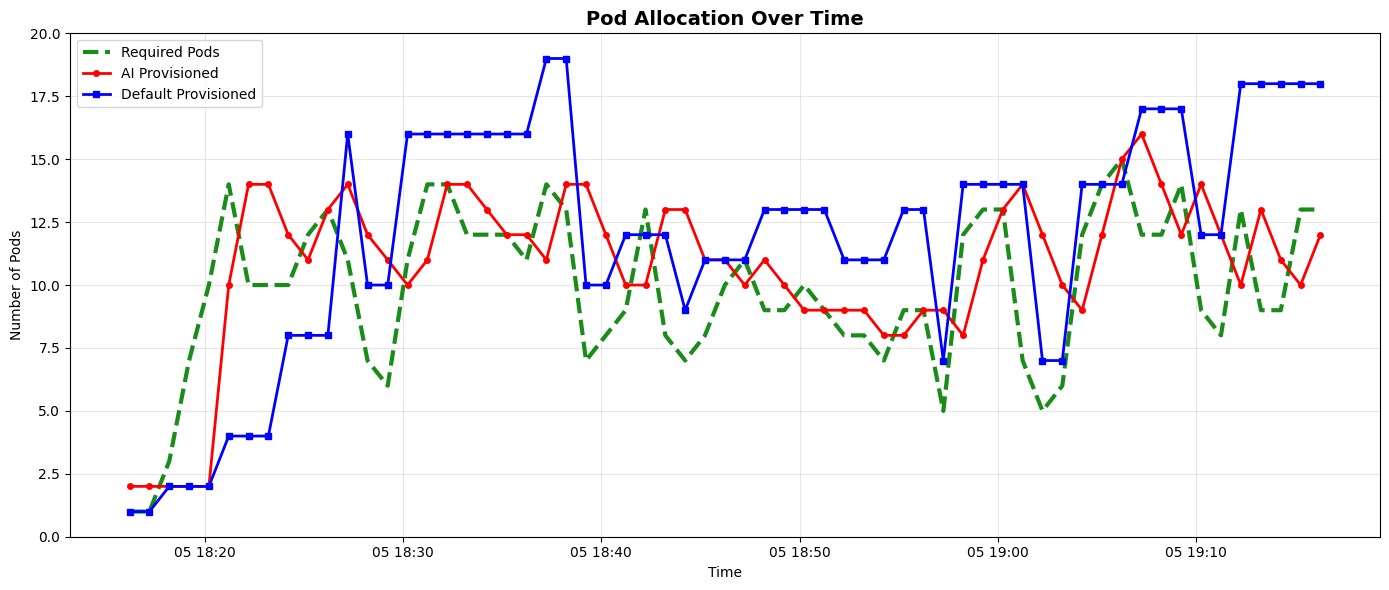

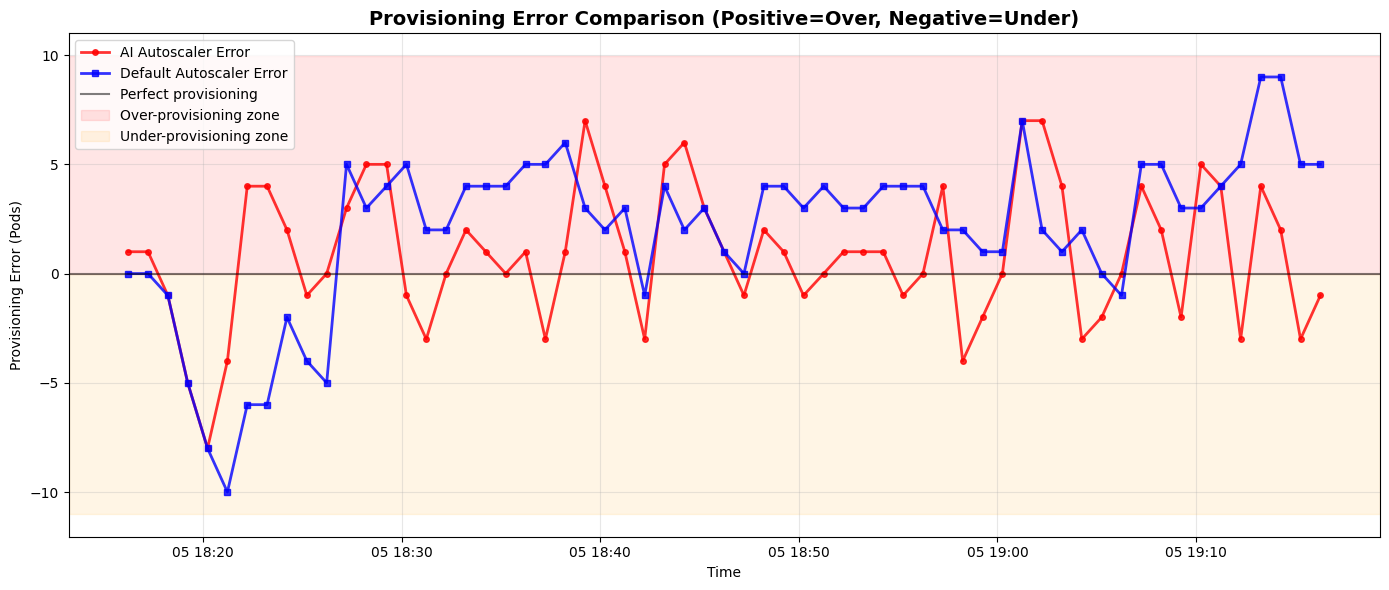


=== AUTOSCALER PERFORMANCE COMPARISON ===
AI Autoscaler Metrics:
  THETA_U: 7.92%
  THETA_O: 25.61%
  T_U: 32.79%
  T_O: 55.74%

Default Autoscaler Metrics:
  THETA_U: 7.91%
  THETA_O: 29.78%
  T_U: 18.03%
  T_O: 75.41%

Elastic Speedup: 0.964

Performance Summary:
  THETA_U_IMPROVEMENT: -0.01%
  THETA_O_IMPROVEMENT: 4.17%
  T_U_IMPROVEMENT: -14.75%
  T_O_IMPROVEMENT: 19.67%
  AI_BETTER_OVERALL: 0.00%


In [13]:
# default k8s autoscaler data proccess
hpa_autoscaler = HpaHttpScaler(
        target_requests_per_pod=workload_per_pod
    )

# ai autoscaler data proccess
data_evaluation = process_autoscaler_data(
        filtered_data=current_request_md, 
        default_autoscaler_instance=hpa_autoscaler,
        initial_replicas=initial_replicas
    )

evaluator = AutoscalerEvaluator(workload_per_pod=workload_per_pod, initial_replicas=initial_replicas)

evaluator.plot_comparison(
        requests=current_request_md,
        ai_provisioned_pods=replicas_md,
        default_provisioned_pods=data_evaluation,
        timestamps=timestamps_md
)